## Step 1: Load the Cleaned Tweet Dataset

We start by loading the cleaned tweet data that includes tokenized and stemmed tweets, along with sentiment labels. We only keep the relevant columns for modeling.


In [3]:
import pandas as pd

# Load dataset
df = pd.read_csv(r"C:\Users\ADMIN\Documents\GitHub\Group4_NLP_Project\data\cleaned_apple_tweets.csv")

# Select the relevant features
df = df[['processed_tweet', 'sentiment']].dropna().reset_index(drop=True)


## Step 2: Encode Sentiment Labels into Numeric Classes

We convert the categorical sentiment labels into numeric values using `LabelEncoder`. This is necessary for scikit-learn models which work with numerical targets.


In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['sentiment'])
df[['sentiment', 'sentiment_encoded']].drop_duplicates()


,sentiment,sentiment_encoded
0,Negative emotion,1
1,Positive emotion,3
5,No emotion toward brand or product,2
89,I can't tell,0


## Step 3: TF-IDF Vectorization of the Processed Tweets

We convert the cleaned tweet text into numerical features using TF-IDF (Term Frequency - Inverse Document Frequency). This helps quantify the importance of each word in the corpus.


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2))
X = tfidf.fit_transform(df['processed_tweet'])

# Target variable
y = df['sentiment_encoded']


## Step 4: Split the Dataset into Training and Testing Sets

We split the dataset using a 70-30 ratio to prepare it for model training and evaluation. We stratify the split to maintain the same label distribution across train and test sets.


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


## Step 5: Split Data into Training and Testing Sets

We start by splitting our dataset into features (`X`) and target labels (`y`). Here, `X` contains the preprocessed tweet text, while `y` holds the sentiment labels. We'll use a 70-30 train-test split with a fixed `random_state` to ensure reproducibility.


In [7]:
from sklearn.model_selection import train_test_split

X = df['processed_tweet']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


## Step 6: Create a Pipeline with TF-IDF Vectorizer and Random Forest Classifier

To simplify the modeling workflow, we use a pipeline that combines text vectorization (TF-IDF) and classification (Random Forest). TF-IDF converts text into numerical vectors, and the Random Forest classifier will learn patterns to predict sentiment.


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1000, ngram_range=(1,2))),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])


## Step 7: Train the Model on the Training Data

Next, we fit the pipeline on the training dataset. This step learns both the vocabulary used in the tweets and the classification rules based on those vectors.


In [9]:
rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=1000, ngram_range=(1, 2))),
                ('rf', RandomForestClassifier(random_state=42))])

## Step 8: Evaluate the Model

After training, we use the model to predict sentiment labels on the test set. We then compute the accuracy to see how well the model generalizes to unseen data.


In [10]:
from sklearn.metrics import accuracy_score

y_pred = rf_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")


Random Forest Accuracy: 0.6648


## Step 9: Visualize Performance with a Confusion Matrix

A confusion matrix shows how often each class was correctly predicted or confused with others. This helps us understand which sentiments are easiest or hardest for the model to identify.


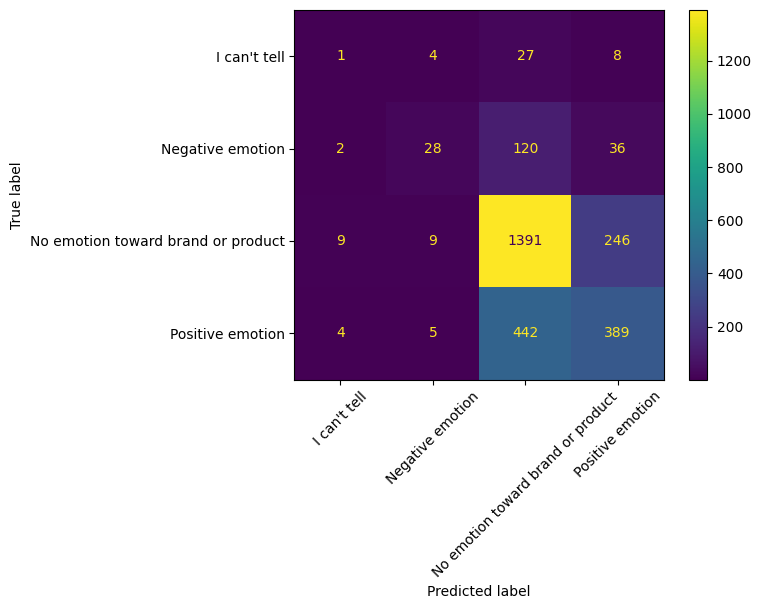

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=rf_pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_pipeline.classes_)
disp.plot(xticks_rotation=45)



## Step 10: Analyzing Feature Importance

Random Forest models offer built-in feature importance scores that tell us which words (features) had the biggest influence on sentiment classification. By inspecting these, we can better understand what terms are driving predictions — such as words highly associated with positive or negative sentiment.

This step helps interpret model behavior and can guide future feature engineering or vocabulary curation.


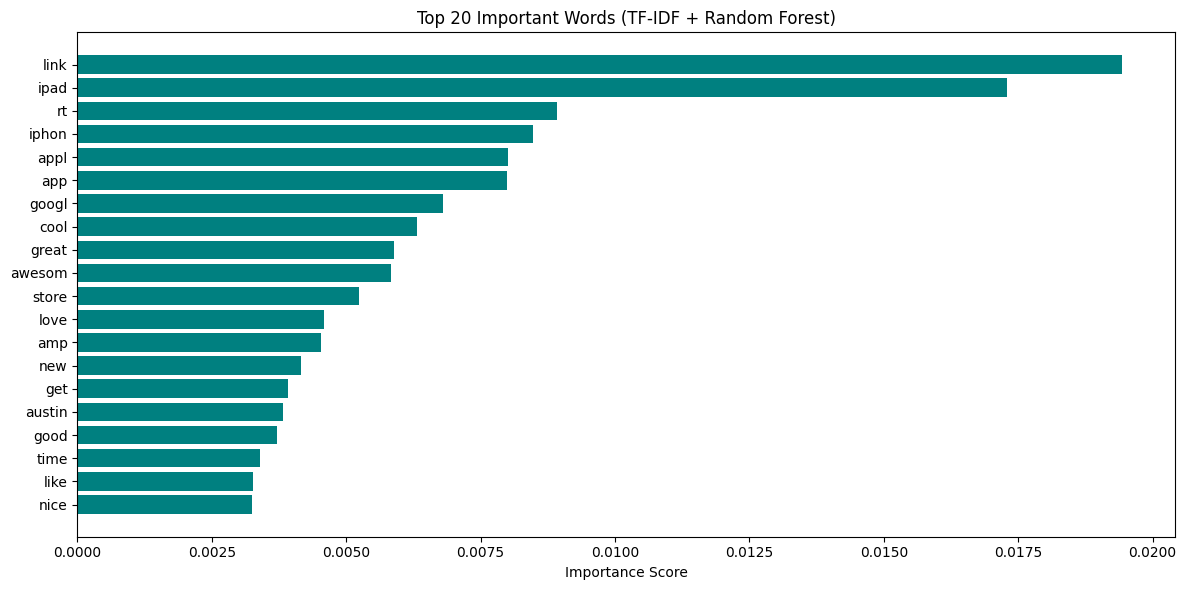

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Extract feature names from the TF-IDF vectorizer
feature_names = nlp_pipe.named_steps['tfidf'].get_feature_names_out()

# Extract feature importances from the Random Forest model
importances = nlp_pipe.named_steps['rf'].feature_importances_

# Create a DataFrame for easier sorting/visualization
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Show top 20 most important features
top_n = 20
top_features = feat_imp_df.head(top_n)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(top_features['feature'][::-1], top_features['importance'][::-1], color='teal')
plt.xlabel("Importance Score")
plt.title(f"Top {top_n} Important Words (TF-IDF + Random Forest)")
plt.tight_layout()
plt.show()


## Hyperparameter Tuning
We performed a grid search with 3-fold cross-validation to find the optimal combination of hyperparameters for the Random Forest model and TF-IDF vectorizer. The search explored various values for the number of trees, maximum depth, and maximum vocabulary size. The best configuration was selected based on weighted F1-score to handle class imbalance.

In [15]:
from sklearn.model_selection import GridSearchCV

# Define pipeline again
nlp_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('rf', RandomForestClassifier(random_state=42))
])

# Define parameter grid
param_grid = {
    'tfidf__max_features': [3000, 5000, 7000],
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20]
}

# Set up GridSearchCV
grid_search = GridSearchCV(nlp_pipe, param_grid, cv=3, n_jobs=-1, verbose=2, scoring='f1_weighted')

# Fit the grid search
grid_search.fit(X, y)

# Save best model
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 18 candidates, totalling 54 fits


## Inspecting the parameters

In [16]:
print("Best parameters:", grid_search.best_params_)


Best parameters: {'rf__max_depth': None, 'rf__n_estimators': 200, 'tfidf__max_features': 5000}


## Evaluating the tuned model
We evaluate the best model on the test set to measure its real-world performance. We consider accuracy, precision, recall, F1-score, and visualize the confusion matrix to assess how well the model distinguishes between the sentiment classes. These metrics help identify which classes the model predicts well and where it struggles, especially given the class imbalance in the dataset

Accuracy: 0.9886071297317163

Classification Report:
                                     precision    recall  f1-score   support

                      I can't tell       0.97      0.95      0.96        40
                  Negative emotion       0.99      1.00      1.00       186
No emotion toward brand or product       0.99      0.99      0.99      1655
                  Positive emotion       0.99      0.98      0.98       840

                          accuracy                           0.99      2721
                         macro avg       0.99      0.98      0.98      2721
                      weighted avg       0.99      0.99      0.99      2721



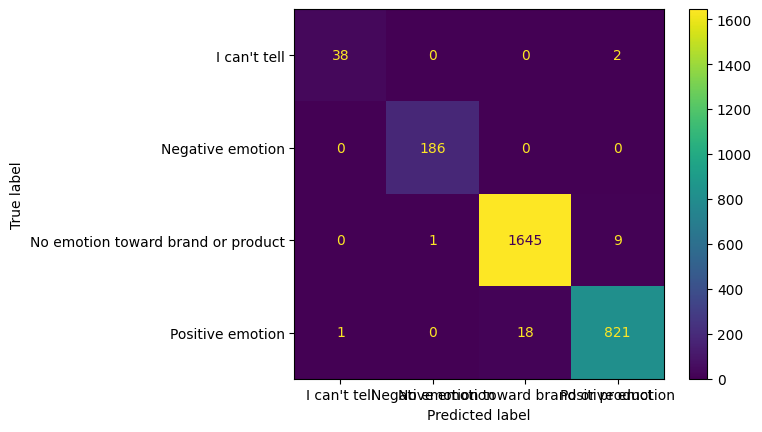

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict
y_pred = best_model.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cfm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=best_model.classes_).plot()
